# Classifying with Natural Language Processing

Today we will be importing data from the "Happy" and "Sad" subreddits on Reddit and using a model to predict which category the titles of the posts in the subreddits come from.

# Table of Contents

- [Word Count Distribution](#Word-Count-Distribution)
- [Multinomial Naive Bayes (Cvec)](#Multinomial-Naive-Bayes-1)
- [Multinomial Naive Bayes (Tvec)](#Multinomial-Naive-Bayes-2)
- [K Nearest Neighbors (Tvec)](#K-Nearest-Neighbors-Classifier)
- [Logistic Regression (Tvec)](#Logistic-Regression)
- [Support Vector Classification (Tvec)](#Support-Vector-Classification)
- [Random Forest Classifier (Cvec)](#Random-Forest-Classifier)
- [Scores of All Models](#Scores-of-All-Models)
- [Confusion Matrices](#Confusion-Matrices)

In [89]:
# Import required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC,SVC
from sklearn.ensemble import RandomForestClassifier

from nltk.corpus import stopwords

In [2]:
# Import the relevant csv of reddit data
df = pd.read_csv('data/happy_sad_2020_08_25_1902.csv')

In [3]:
# Drop NaN rows after checking for nulls. In this case there is only a single entry and it shouldn't affect our data.
df.dropna(inplace=True)

### Word Count Distribution

In [4]:
# Count and visualize title lengths and word counts.
# code from Lab 5.02 work on counting string lengths and word counts
df['title_length'] = df['title'].str.len()
df['title_word_count'] = df['title'].str.split().str.len()

print(df[df['target']==1]['title_length'].mean())
print(df[df['target']==0]['title_length'].mean())

94.0642
39.6979697969797


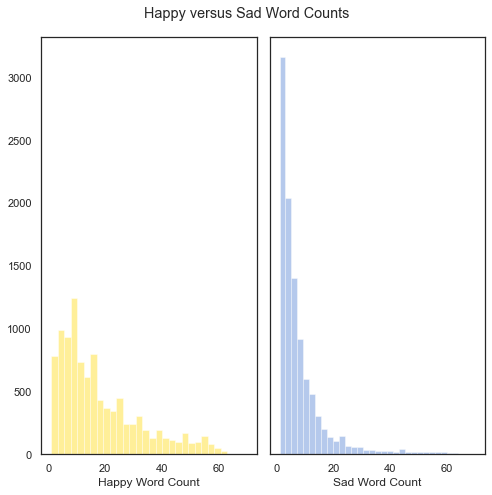

In [185]:
# Visualize the distribution of Happy word counts versus Sad word counts
sns.set(style='white',palette='muted',color_codes=True)

f, axes = plt.subplots(1,2, figsize=(7,7), sharex=True, sharey=True)

sns.distplot(df[df['target']==1]['title_word_count'],bins=30,kde=False,color='gold', ax=axes[0],axlabel='Happy Word Count')
sns.distplot(df[df['target']==0]['title_word_count'],bins=30,kde=False, color='b', ax=axes[1],axlabel='Sad Word Count')
plt.suptitle('Happy versus Sad Word Counts')
plt.tight_layout()
plt.savefig('images/wordcount.png',format='png')

In [6]:
# Checking out the baseline accuracy. As we have an almost equal amount of each class 
# it is expected that it will be about 0.5
X = df['title']
y = df['target']

In [101]:
# The counts of the target variable are normalized to get the percentage for 1 (happy) and 0 (sad).
y.value_counts(normalize=True)

1    0.500025
0    0.499975
Name: target, dtype: float64

In [7]:
# Setting up the train-test-split for our modeling
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    train_size = 0.7,
                                                    random_state=42,
                                                    shuffle=True,
                                                    stratify=y)

In [9]:
stops = set(stopwords.words('english')) # Removing stop words for counting the most common words
# Using count vectorizer to build a dataframe to count the most frequent words
vectorizer = CountVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = stops,
                             max_features = None) 

In [10]:
vectorized_words = vectorizer.fit(df['title'])
word_vector = vectorizer.transform(df['title'])

In [11]:
my_words_df = pd.DataFrame(word_vector.toarray(),columns=vectorizer.get_feature_names())

In [106]:
#Lesson...5.something
# This function with condense the counts of the vectorized dataframe into a sorted list of the 
# most frequent words.
def count_words(my_words_df, rows=5):
    # empty dictionary
    top_words = {}

    # loop through columns
    for i in my_words_df.columns:
        # save sum of each column in dictionary
        top_words[i] =  my_words_df[i].sum()

    # top_words to dataframe sorted by highest occurance
    most_freq = pd.DataFrame(sorted(top_words.items(), key = lambda x: x[1], reverse = True))
    return most_freq

In [108]:
word_freq = count_words(my_words_df)

In [110]:
# The top 20 most frequent words.
word_freq.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,happy,today,life,sad,got,first,years,day,time,feel,finally,love,like,made,year,one,get,good,best,know
1,2474,1287,1189,1174,1113,1059,1029,1001,970,959,902,900,853,815,744,718,620,592,575,567


### Multinomial Naive Bayes 1
> Count Vectorizer

In [45]:
# The first model attempted is multinomial bayes. Before each model a model_params dictionary is initialized
# to store the parameters from each grid search. 
model_params = {}
# The count names the index for the next set of parameters appended to the dictionary.
count = 0

In [52]:
# Lesson 5.04 code
# An initial time stamp is created to keep track of the overall time to run the grid search cv of the model.
t0 = time.time()

# A pipeline is created to run the training data through the vectorizer of choice for the model
# and select the model.
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

# A set of parameters is inserted into a dictionary 

# It is important to note that all the various parameters attempted are not stored 
# within this scaffolding. 
pipe_params = {
    'cvec__max_features': [5_250],
    'cvec__min_df': [1, 2],
    'cvec__max_df': [0.25,0.30,0.35, 0.40, 0.45,0.50],
    'cvec__ngram_range': [(1,1)],
    'cvec__stop_words': [None,'english'] # Stop words were explored initiallty 
}
# Instantiating the grid search
gs = GridSearchCV(pipe, # Use the pipe to set our vectorizer and classifier
                  param_grid=pipe_params, # Assign the grid search parameters
                  cv=5, # Set up a 5-fold cross-validation
                  n_jobs=4) # Use 4 threads to speed up the gird search

# Fit the grid search to training data
gs.fit(X_train, y_train)
# Update the count of the model name
count +=1

# Save the parameters to the dictionary and then display as a data frame
gs.best_params_['score'] = gs.best_score_
model_params[f'model_{count}'] = gs.best_params_

# Total run time
print(f'Run time: {time.time()-t0}')

# Convert the dictionary into a data frame and then show it.
model_df = pd.DataFrame.from_dict(model_params,orient='index')
model_df

Run time: 3.316492795944214


,cvec__max_df,cvec__max_features,cvec__min_df,cvec__ngram_range,cvec__stop_words,score
model_1,0.90,5000,2,"(1, 1)",None,0.814989
model_2,0.85,5000,1,"(1, 1)",None,0.815060
model_3,0.75,5250,1,"(1, 1)",None,0.815774
model_4,0.65,5250,1,"(1, 1)",None,0.815774
model_5,0.55,5250,1,"(1, 1)",None,0.815774
model_6,0.35,5250,1,"(1, 1)",None,0.815774
model_7,0.35,5250,1,"(1, 1)",None,0.815774


In [111]:
# This section is for running the final parameters as a unique grid search with a next name.
# The same scaffolding is used as before but only one option is set for each hyper parameter. 
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

pipe_params = {
    'cvec__max_features': [5_250],
    'cvec__min_df': [1],
    'cvec__max_df': [0.35],
    'cvec__ngram_range': [(1,1)],
    'cvec__stop_words': [None]
}

gs_nb1 = GridSearchCV(pipe, 
                  param_grid=pipe_params, 
                  cv=5, 
                  n_jobs=4) 

gs_nb1.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=4,
             param_grid={'cvec__max_df': [0.35], 'cvec__max_features': [5250],
                         'cvec__min_df': [1], 'cvec__ngram_range': [(1, 1)],
                         'cvec__stop_words': [None]})

In [114]:
# The score is printed showing the comparison between training and testing.
print(f'Multinomial Naive Bayes 1 Testing Accuracy: {gs_nb1.score(X_train, y_train)}\n')
print(f'Multinomial Naive Bayes 1 Testing Accuracy: {gs_nb1.score(X_test, y_test)}\n')

Multinomial Naive Bayes 1 Testing Accuracy: 0.8547753410957926

Multinomial Naive Bayes 1 Testing Accuracy: 0.813



In [127]:
# Building a storage location for final scores. Each model will add a new entry with the parameters
# selected after the grid search.
final_df = pd.DataFrame(np.array([['Mutinomial Naive Bayes 1',gs_nb1.score(X_train, y_train),gs_nb1.score(X_test, y_test)]]),
                       columns = ['model', 'training_score','testing_score'])

In [117]:
# First iteration of the final data frame with each model's score
final_df

,model,training_score,testing_score
0,Mutinomial Naive Bayes 1,0.8547753410957926,0.813


### Multinomial Naive Bayes 2
> Term Frequency Inverse Document Frequency Vectorizer

In [55]:
model_params = {}
count = 0

In [62]:
t0 = time.time()

pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

pipe_params = {
    'tvec__max_features': [4_000],
    'tvec__stop_words': [None],
    'tvec__min_df': [1,2],
    'tvec__max_df': [0.1,0.2,0.25,0.3,0.35],
    'tvec__ngram_range': [(1,1)]
}

gs = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5, # 5-fold cross-validation.
                  n_jobs=4)

gs.fit(X_train, y_train)

count += 1

gs.best_params_['score'] = gs.best_score_
model_params[f'model_{count}'] = gs.best_params_
print(f'Run time: {time.time()-t0}')
model_df = pd.DataFrame.from_dict(model_params,orient='index')
model_df

Run time: 3.13055419921875


,tvec__max_df,tvec__max_features,tvec__min_df,tvec__ngram_range,tvec__stop_words,score
model_0,0.90,4000,2,"(1, 1)",None,0.819417
model_2,0.70,4000,2,"(1, 1)",None,0.819417
model_3,0.30,4000,2,"(1, 1)",None,0.819489
model_4,0.25,4000,2,"(1, 1)",None,0.819632


In [118]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

pipe_params = {
    'tvec__max_features': [4_000],
    'tvec__stop_words': [None],
    'tvec__min_df': [2],
    'tvec__max_df': [0.25],
    'tvec__ngram_range': [(1,1)]
}

gs_nb2 = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5, # 5-fold cross-validation.
                  n_jobs=4)

gs_nb2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=4,
             param_grid={'tvec__max_df': [0.25], 'tvec__max_features': [4000],
                         'tvec__min_df': [2], 'tvec__ngram_range': [(1, 1)],
                         'tvec__stop_words': [None]})

In [119]:
print(f'Multinomial Naive Bayes 2 Training Accuracy: {gs_nb2.score(X_train, y_train)}\n')
print(f'Multinomial Naive Bayes 2 Testing Accuracy: {gs_nb2.score(X_test, y_test)}\n')

Multinomial Naive Bayes 2 Training Accuracy: 0.8567754839631402

Multinomial Naive Bayes 2 Testing Accuracy: 0.8143333333333334



In [128]:
array = np.array([['Multinomial Naive Bayes 2', gs_nb2.score(X_train, y_train), gs_nb2.score(X_test, y_test)]])
final_df = final_df.append(pd.DataFrame(array,columns = ['model', 'training_score','testing_score']))
final_df

,model,training_score,testing_score
0,Mutinomial Naive Bayes 1,0.8547753410957926,0.813
0,Multinomial Naive Bayes 2,0.8567754839631402,0.8143333333333334


### K Nearest Neighbors Classifier
> Term Frequency Inverse Document Frequency Vectorizer

In [65]:
model_params = {}
count = 0

In [78]:
t0 = time.time()

pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    #('sc', StandardScaler()),
    ('knn', KNeighborsClassifier())
    
])

pipe_params = {
    'tvec__max_features': [1_000,3_000,4_000],
    'tvec__stop_words': [None],
    'tvec__min_df': [1,2],
    'tvec__max_df': [0.1,0.2,0.25,0.3,0.35],
    'tvec__ngram_range': [(1,1)],
    'knn__n_neighbors' : [3,5,9,13],
    'knn__metric' : ['minkowski']
    
}

gs = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5, # 5-fold cross-validation.
                  n_jobs=4,
                  verbose = 2)

gs.fit(X_train, y_train)

count += 1

gs.best_params_['score'] = gs.best_score_
model_params[f'model_{count}'] = gs.best_params_
print(f'Run time: {time.time()-t0}')
model_df = pd.DataFrame.from_dict(model_params,orient='index')
model_df

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   13.4s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   58.1s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 600 out of 600 | elapsed:  3.5min finished


Run time: 210.87307214736938


,knn__metric,knn__n_neighbors,tvec__max_df,tvec__max_features,tvec__min_df,tvec__ngram_range,tvec__stop_words,score
model_1,minkowski,3,0.2,1000,1,"(1, 1)",None,0.613401


In [129]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('knn', KNeighborsClassifier())
    
])

pipe_params = {
    'tvec__max_features': [1_000],
    'tvec__stop_words': [None],
    'tvec__min_df': [1],
    'tvec__max_df': [0.2],
    'tvec__ngram_range': [(1,1)],
    'knn__n_neighbors' : [3],
    'knn__metric' : ['minkowski']
    
}

gs_knn = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5, # 5-fold cross-validation.
                  n_jobs=4,
                  verbose = 2)

gs_knn.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    5.1s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=4,
             param_grid={'knn__metric': ['minkowski'], 'knn__n_neighbors': [3],
                         'tvec__max_df': [0.2], 'tvec__max_features': [1000],
                         'tvec__min_df': [1], 'tvec__ngram_range': [(1, 1)],
                         'tvec__stop_words': [None]},
             verbose=2)

In [174]:
print(f'KNN Training Accuracy: {gs_knn.score(X_train, y_train)}\n')
print(f'KNN Testing Accuracy: {gs_knn.score(X_test, y_test)}\n')

KNN Training Accuracy: 0.9126366169012072

KNN Testing Accuracy: 0.6355



In [131]:
array = np.array([['K Nearest Neighbors', gs_knn.score(X_train, y_train), gs_knn.score(X_test, y_test)]])
final_df = final_df.append(pd.DataFrame(array,columns = ['model', 'training_score','testing_score']))
final_df

,model,training_score,testing_score
0,Mutinomial Naive Bayes 1,0.8547753410957926,0.813
0,Multinomial Naive Bayes 2,0.8567754839631402,0.8143333333333334
0,K Nearest Neighbors,0.9126366169012072,0.6355


### Logistic Regression
> Term Frequency Inverse Document Frequency Vectorizer

In [80]:
model_params = {}
count = 0

In [83]:
t0 = time.time()

pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    #('sc', StandardScaler()),
    ('logreg', LogisticRegression())
    
])

pipe_params = {
    'tvec__max_features': [4_000,5_000,6_000],
    'tvec__stop_words': [None],
    'tvec__min_df': [2,3],
    'tvec__max_df': [0.25],
    'tvec__ngram_range': [(1,2)],
    'logreg__penalty' : ['l2'],
    'logreg__solver' : ['saga'],
    'logreg__max_iter' : [500],
    'logreg__C' : [3, 5, 7]
    
}

gs = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5, # 5-fold cross-validation.
                  n_jobs=4,
                  verbose = 2)

gs.fit(X_train, y_train)

count += 1

gs.best_params_['score'] = gs.best_score_
model_params[f'model_{count}'] = gs.best_params_
print(f'Run time: {time.time()-t0}')
model_df = pd.DataFrame.from_dict(model_params,orient='index')
model_df

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    5.8s
[Parallel(n_jobs=4)]: Done  90 out of  90 | elapsed:   13.7s finished


Run time: 14.226673126220703


,logreg__C,logreg__max_iter,logreg__penalty,logreg__solver,tvec__max_df,tvec__max_features,tvec__min_df,tvec__ngram_range,tvec__stop_words,score
model_1,5,500,l2,saga,0.25,5000,2,"(1, 2)",None,0.856489
model_2,5,500,l2,saga,0.25,5000,2,"(1, 2)",None,0.856418


In [132]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('logreg', LogisticRegression())
    
])

pipe_params = {
    'tvec__max_features': [5_000],
    'tvec__stop_words': [None],
    'tvec__min_df': [2],
    'tvec__max_df': [0.25],
    'tvec__ngram_range': [(1,2)],
    'logreg__penalty' : ['l2'],
    'logreg__solver' : ['saga'],
    'logreg__max_iter' : [500],
    'logreg__C' : [5]
    
}

gs_lr = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5, # 5-fold cross-validation.
                  n_jobs=4,
                  verbose = 2)

gs_lr.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.6s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('logreg', LogisticRegression())]),
             n_jobs=4,
             param_grid={'logreg__C': [5], 'logreg__max_iter': [500],
                         'logreg__penalty': ['l2'], 'logreg__solver': ['saga'],
                         'tvec__max_df': [0.25], 'tvec__max_features': [5000],
                         'tvec__min_df': [2], 'tvec__ngram_range': [(1, 2)],
                         'tvec__stop_words': [None]},
             verbose=2)

In [137]:
print(f'Logistic Regression Training Accuracy: {gs_lr.score(X_train, y_train)}\n')
print(f'Logistic Regression Testing Accuracy: {gs_lr.score(X_test, y_test)}\n')

Logistic Regression Training Accuracy: 0.9315665404671762

Logistic Regression Testing Accuracy: 0.8566666666666667



In [134]:
array = np.array([['Logistic Regression', gs_lr.score(X_train, y_train), gs_lr.score(X_test, y_test)]])
final_df = final_df.append(pd.DataFrame(array,columns = ['model', 'training_score','testing_score']))
final_df

,model,training_score,testing_score
0,Mutinomial Naive Bayes 1,0.8547753410957926,0.813
0,Multinomial Naive Bayes 2,0.8567754839631402,0.8143333333333334
0,K Nearest Neighbors,0.9126366169012072,0.6355
0,Logistic Regression,0.9315665404671762,0.8566666666666667


### Support Vector Classification
> Term Frequency Inverse Document Frequency Vectorizer

In [96]:
model_params = {}
count = 0

In [100]:
t0 = time.time()

pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('svc', SVC())
    
])

pipe_params = {
    'tvec__max_features': [5_000],
    'tvec__stop_words': [None],
    'tvec__min_df': [2],
    'tvec__max_df': [0.2],
    'tvec__ngram_range': [(1,1)],
    'svc__kernel' : ['rbf'],
    'svc__max_iter' : [-1],
    'svc__degree':[2],
    'svc__C' : [5,10],
    'svc__gamma' : ['scale']
}

gs = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5, # 5-fold cross-validation.
                  n_jobs=4,
                  verbose = 2)

gs.fit(X_train, y_train)

count += 1

gs.best_params_['score'] = gs.best_score_
model_params[f'model_{count}'] = gs.best_params_
print(f'Run time: {time.time()-t0}')
model_df = pd.DataFrame.from_dict(model_params,orient='index')
model_df

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:  1.3min finished


Run time: 116.18785619735718


,svc__degree,svc__kernel,svc__max_iter,tvec__max_df,tvec__max_features,tvec__min_df,tvec__ngram_range,tvec__stop_words,score,svc__C,svc__gamma
model_1,2,poly,-1,0.2,5000,2,"(1, 1)",None,0.856776,NaN,NaN
model_2,2,rbf,-1,0.2,5000,2,"(1, 1)",None,0.859704,NaN,NaN
model_3,2,rbf,-1,0.2,5000,2,"(1, 1)",None,0.863205,10.0,scale
model_4,2,rbf,-1,0.2,5000,2,"(1, 1)",None,0.863205,10.0,scale


In [135]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('svc', SVC())
    
])

pipe_params = {
    'tvec__max_features': [5_000],
    'tvec__stop_words': [None],
    'tvec__min_df': [2],
    'tvec__max_df': [0.2],
    'tvec__ngram_range': [(1,1)],
    'svc__kernel' : ['rbf'],
    'svc__max_iter' : [-1],
    'svc__degree':[2],
    'svc__C' : [10],
    'svc__gamma' : ['scale']
}

gs_svc = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5, # 5-fold cross-validation.
                  n_jobs=4,
                  verbose = 2)

gs_svc.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   59.4s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('svc', SVC())]),
             n_jobs=4,
             param_grid={'svc__C': [10], 'svc__degree': [2],
                         'svc__gamma': ['scale'], 'svc__kernel': ['rbf'],
                         'svc__max_iter': [-1], 'tvec__max_df': [0.2],
                         'tvec__max_features': [5000], 'tvec__min_df': [2],
                         'tvec__ngram_range': [(1, 1)],
                         'tvec__stop_words': [None]},
             verbose=2)

In [138]:
print(f'Support Vector Classification Training Accuracy: {gs_svc.score(X_train, y_train)}\n')
print(f'Support Vector Classification Testing Accuracy: {gs_svc.score(X_test, y_test)}\n')

Support Vector Classification Training Accuracy: 0.9924994642474463

Support Vector Classification Testing Accuracy: 0.8645



In [139]:
array = np.array([['Support Vector Classification', gs_svc.score(X_train, y_train), gs_svc.score(X_test, y_test)]])
final_df = final_df.append(pd.DataFrame(array,columns = ['model', 'training_score','testing_score']))
final_df

,model,training_score,testing_score
0,Mutinomial Naive Bayes 1,0.8547753410957926,0.813
0,Multinomial Naive Bayes 2,0.8567754839631402,0.8143333333333334
0,K Nearest Neighbors,0.9126366169012072,0.6355
0,Logistic Regression,0.9315665404671762,0.8566666666666667
0,Support Vector Classification,0.9924994642474463,0.8645


### Random Forest Classifier
> Count Vectorizer

In [90]:
model_params = {}
count = 0

In [94]:
t0 = time.time()

pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier())
    
])

pipe_params = {
    'cvec__max_features': [4_000, 5_000,6_000],
    'cvec__stop_words': [None],
    'cvec__min_df': [1,2],
    'cvec__max_df': [0.1,0.2],
    'cvec__ngram_range': [(1,1),(1,2)],
    'rf__ccp_alpha' : [0.001,0.1],    
}

gs = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5, # 5-fold cross-validation.
                  n_jobs=4,
                  verbose = 2)

gs.fit(X_train, y_train)

count += 1

gs.best_params_['score'] = gs.best_score_
model_params[f'model_{count}'] = gs.best_params_
print(f'Run time: {time.time()-t0}')
model_df = pd.DataFrame.from_dict(model_params,orient='index')
model_df

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 160 out of 160 | elapsed:  6.0min finished


Run time: 373.2064609527588


,score,cvec__max_df,cvec__max_features,cvec__min_df,cvec__ngram_range,cvec__stop_words,rf__ccp_alpha
model_1,0.825987,NaN,NaN,NaN,NaN,NaN,NaN
model_2,0.826130,NaN,NaN,NaN,NaN,NaN,NaN
model_3,0.798414,0.2,5000.0,2.0,"(1, 1)",NaN,0.001


In [140]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier())
    
])

pipe_params = {  
}

gs_rf = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5, # 5-fold cross-validation.
                  n_jobs=4,
                  verbose = 2)

gs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   25.8s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=4, param_grid={}, verbose=2)

In [141]:
print(f'Random Forest Classifier Training Accuracy: {gs_rf.score(X_train, y_train)}\n')
print(f'Random Forest Classifier Testing Accuracy: {gs_rf.score(X_test, y_test)}\n')

Random Forest Classifier Training Accuracy: 0.9962854489606401

Random Forest Classifier Testing Accuracy: 0.8226666666666667



In [142]:
array = np.array([['Random Forest Classifier', gs_rf.score(X_train, y_train), gs_rf.score(X_test, y_test)]])
final_df = final_df.append(pd.DataFrame(array,columns = ['model', 'training_score','testing_score']))
final_df

,model,training_score,testing_score
0,Mutinomial Naive Bayes 1,0.8547753410957926,0.813
0,Multinomial Naive Bayes 2,0.8567754839631402,0.8143333333333334
0,K Nearest Neighbors,0.9126366169012072,0.6355
0,Logistic Regression,0.9315665404671762,0.8566666666666667
0,Support Vector Classification,0.9924994642474463,0.8645
0,Random Forest Classifier,0.9962854489606401,0.8226666666666667


In [145]:
final_df.reset_index(inplace=True)

In [151]:
final_df['training_score'] = final_df['training_score'].map(lambda x: round(float(x),2))
final_df['testing_score'] = final_df['testing_score'].map(lambda x: round(float(x),2))

In [153]:
final_df.drop('index',axis=1,inplace=True)

### Scores of All Models

In [154]:
final_df

,model,training_score,testing_score
0,Mutinomial Naive Bayes 1,0.85,0.81
1,Multinomial Naive Bayes 2,0.86,0.81
2,K Nearest Neighbors,0.91,0.64
3,Logistic Regression,0.93,0.86
4,Support Vector Classification,0.99,0.86
5,Random Forest Classifier,1.00,0.82


In [161]:
def pandas_df_to_markdown_table(df):
    from IPython.display import Markdown, display
    fmt = ['---' for i in range(len(df.columns))]
    df_fmt = pd.DataFrame([fmt], columns=df.columns)
    df_formatted = pd.concat([df_fmt, df])
    display(Markdown(df_formatted.to_csv(sep="|", index=False)))

pandas_df_to_markdown_table(final_df)

model|training_score|testing_score
---|---|---
Mutinomial Naive Bayes 1|0.85|0.81
Multinomial Naive Bayes 2|0.86|0.81
K Nearest Neighbors|0.91|0.64
Logistic Regression|0.93|0.86
Support Vector Classification|0.99|0.86
Random Forest Classifier|1.0|0.82


## Confusion Matrices

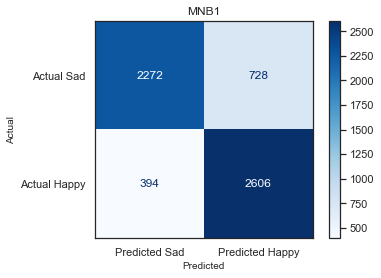

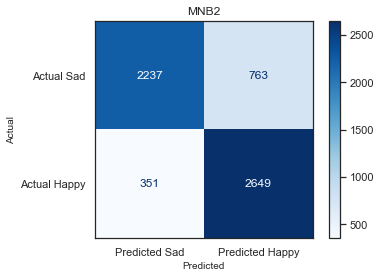

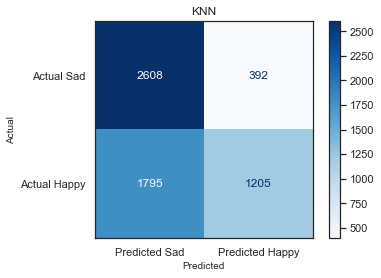

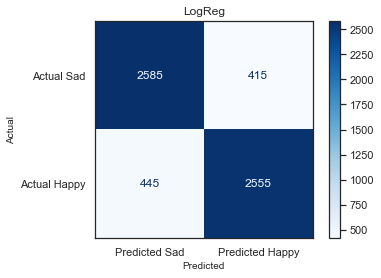

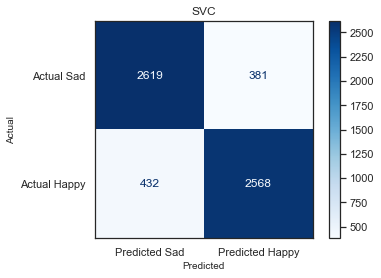

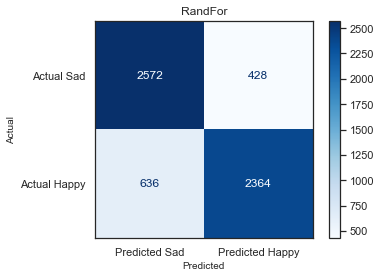

In [173]:
# Creating a Confusion Matrix for each model.
for model,name in [(gs_nb1,'MNB1'),(gs_nb2,'MNB2'),(gs_knn,'KNN'),(gs_lr,'LogReg'),(gs_svc,'SVC'),(gs_rf,'RandFor')]:
    # This confusion matrix code is from class.
    # Get predictions for the model in the list
    preds = model.predict(X_test)

    # save confusion matrix values
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    
    # Show the confusion matrix for the model

    plot_confusion_matrix(model, X_test, y_test, cmap='Blues', values_format='d')
    plt.title(name)
    plt.xlabel('Predicted',size=15)
    plt.ylabel('Actual',size=15)
    plt.xticks(ticks=[0,1],labels=['Predicted Sad', 'Predicted Happy'])
    plt.yticks(ticks=[0,1],labels=['Actual Sad', 'Actual Happy'])
    plt.savefig('images/'+name+'.png',format='png')
    plt.show();